# Training and Evaluating a POS Tagger

In [1]:
%load_ext autoreload
%autoreload 2

In [434]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re

import spacy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models.keyedvectors import load_word2vec_format
from gensim.models import Word2Vec, KeyedVectors

import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, confusion_matrix

from training import get_embedding_weights, POSDataset, Model, train_eval
from preprocessing import split_text_into_lines, extract_text_and_target, encode_text
from analysis import plot_learning_curve, inference_with_metrics, get_analysis_dataframe

## Preprocessing

### Create dataframe

In [555]:
with open('train.txt') as f:
    train_data = f.readlines()
with open('test.txt') as f:
    test_data = f.readlines()

In [556]:
# split text into lines

train_lines = split_text_into_lines(train_data)
test_lines = split_text_into_lines(test_data)

In [557]:
# put extract text and target from lines

train_text, train_targets = extract_text_and_target(train_lines)
test_text, test_targets = extract_text_and_target(test_lines)

In [558]:
train_df = pd.DataFrame(data={"text": train_text, "target": train_targets, "stage": ["train" for x in train_text]})
test_df = pd.DataFrame(data={"text": test_text, "target": test_targets, "stage": ["test" for x in test_text]})

In [559]:
df = pd.concat([train_df, test_df], axis=0)

In [560]:
df.head()

,text,target,stage
0,"[Confidence, in, the, pound, is, widely, expec...","[NN, IN, DT, NN, VBZ, RB, VBN, TO, VB, DT, JJ,...",train
1,"[Chancellor, of, the, Exchequer, Nigel, Lawson...","[NNP, IN, DT, NNP, NNP, NNP, POS, VBN, NN, TO,...",train
2,"[But, analysts, reckon, underlying, support, f...","[CC, NNS, VBP, VBG, NN, IN, NN, VBZ, VBN, VBN,...",train
3,"[This, has, increased, the, risk, of, the, gov...","[DT, VBZ, VBN, DT, NN, IN, DT, NN, VBG, VBN, T...",train
4,"[``, The, risks, for, sterling, of, a, bad, tr...","[``, DT, NNS, IN, NN, IN, DT, JJ, NN, NN, VBP,...",train


In [546]:
# check if length of text and target are the same for each sample

for idx, row in df.iterrows():
    if len(row["text"]) != len(row["target"]):
        print(idx)

### EDA

In [548]:
print(
    f"Total number of sentences:\n" 
    f"Training set {len(train_df)}\n"
    f"Test set {len(test_df)}"
)

Total number of sentences:
Training set 8937
Test set 2013


In [550]:
avg_train_sent_length = np.mean([len(row["text"]) for _, row in train_df.iterrows()])
avg_test_sent_length = np.mean([len(row["text"]) for _, row in test_df.iterrows()])
    
print(
    f"Avg. number of words per sentence:\n"
    f"Training set: {avg_train_sent_length:.1f}\n"
    f"Test set: {avg_test_sent_length:.1f}"
)

Avg. number of words per sentence:
Training set: 23.7
Test set: 23.5


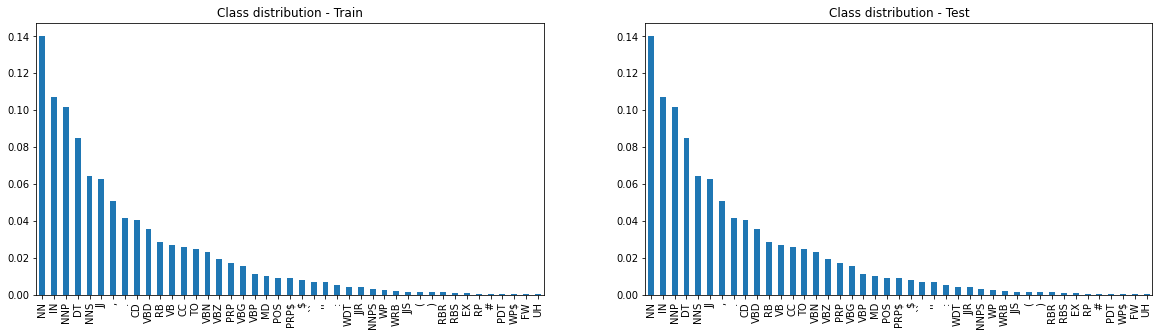

In [554]:
plt.figure(figsize=(20,5))

for plot, (string, data) in enumerate(zip(["Train", "Test"], [train_df, test_df])):
    
    pos_tags = list()
    for idx, row in df.iterrows():
        pos_tags.extend(row["target"])

    plt.subplot(1, 2, plot+1)
    pd.Series(pos_tags).value_counts(normalize=True).plot.bar()
    plt.title(f"Class distribution - {string}")
    
plt.show()

### Targets

In [561]:
# get all unique POS tags

unique_pos_tags = set()
for idx, row in df.iterrows():
    for tag in row["target"]:
        if tag not in unique_pos_tags:
            unique_pos_tags.add(tag)

print(unique_pos_tags)

{'CC', '.', 'VBD', 'JJS', 'VB', 'FW', ':', 'IN', 'VBG', 'WRB', 'POS', ',', 'NNS', 'RBR', 'WP', 'PDT', 'JJ', 'UH', 'NNPS', 'TO', '``', 'RBS', 'WDT', '#', '$', 'RB', 'JJR', 'NNP', 'MD', 'NN', 'VBN', 'VBP', 'PRP$', '(', "''", 'EX', 'WP$', 'CD', 'DT', 'RP', ')', 'PRP', 'VBZ', 'SYM'}


In [562]:
# create numerical encodings for POS tags

pos2value = dict()
pos2value[0] = 0
for idx, tag in enumerate(unique_pos_tags):
    pos2value[tag] = idx + 1  # because 0 will be padding token in both text and target

value2pos = {v: k for k, v in pos2value.items()}

print(pos2value)

{0: 0, 'CC': 1, '.': 2, 'VBD': 3, 'JJS': 4, 'VB': 5, 'FW': 6, ':': 7, 'IN': 8, 'VBG': 9, 'WRB': 10, 'POS': 11, ',': 12, 'NNS': 13, 'RBR': 14, 'WP': 15, 'PDT': 16, 'JJ': 17, 'UH': 18, 'NNPS': 19, 'TO': 20, '``': 21, 'RBS': 22, 'WDT': 23, '#': 24, '$': 25, 'RB': 26, 'JJR': 27, 'NNP': 28, 'MD': 29, 'NN': 30, 'VBN': 31, 'VBP': 32, 'PRP$': 33, '(': 34, "''": 35, 'EX': 36, 'WP$': 37, 'CD': 38, 'DT': 39, 'RP': 40, ')': 41, 'PRP': 42, 'VBZ': 43, 'SYM': 44}


In [563]:
# encode targets in train and test set

targets_encoded = list()
for idx, row in df.iterrows():
    target_encoded = list()
    for tag in row["target"]:
        target_encoded.append(pos2value[tag])
    targets_encoded.append(target_encoded)

In [564]:
# get max sentence lengths sentence_lengths = [len(row["text"]) for idx, row in train_df.iterrows()]

max_seq_length = max(sentence_lengths)
print("Median sentence length", np.median(sentence_lengths))
print("Max sentence length", max_seq_length)

Median sentence length 23.0
Max sentence length 78


In [565]:
# pad targets to max sentence length

targets_padded = pad_sequences(targets_encoded, maxlen=max_seq_length, padding='post')
targets_padded = [target.tolist() for target in targets_padded]

In [566]:
print(f"Example target:\n"
      f"Length before padding: {len(targets_encoded[0])}\n"
      f"Length after padding: {len(targets_padded[0])}")

Example target:
Length before padding: 37
Length after padding: 78


In [567]:
df["target_encoded"] = targets_encoded
df["target_padded"] = targets_padded

### Inputs

#### Word IDs

In [568]:
# encode text

tokenizer = Tokenizer(filters="")
text_encoded, word2value = encode_text(df["text"], tokenizer)

In [569]:
# pad text

texts_padded = pad_sequences(text_encoded, maxlen=max_seq_length, padding='post')
texts_padded = [text.tolist() for text in texts_padded]

In [570]:
df["text_encoded"] = text_encoded
df["text_padded"] = texts_padded

In [571]:
print(f"Example text:\n"
      f"Length before padding: {len(text_encoded[0])}\n"
      f"Length after padding: {len(texts_padded[0])}")

Example text:
Length before padding: 37
Length after padding: 78


In [572]:
# check if padded text and padded targets have the same length

for idx in range(len(df)):
    if len(df["text_padded"].iloc[idx]) != len(df["target_padded"].iloc[idx]):
        print(idx)

In [573]:
df.sample(3)

,text,target,stage,target_encoded,target_padded,text_encoded,text_padded
3581,"[Only, at, the, moment, of, maximum, roll, did...","[RB, IN, DT, NN, IN, JJ, NN, VBD, PRP, VBP, WP...",train,"[26, 8, 39, 30, 8, 17, 30, 3, 42, 32, 15, 3, 9...","[26, 8, 39, 30, 8, 17, 30, 3, 42, 32, 15, 3, 9...","[90, 20, 2, 1309, 4, 2754, 2487, 158, 69, 8603...","[90, 20, 2, 1309, 4, 2754, 2487, 158, 69, 8603..."
4304,"[``, I, see, it, as, a, sewage, treatment, pla...","[``, PRP, VBP, PRP, IN, DT, NN, NN, NN, ,, '',...",train,"[21, 42, 32, 42, 8, 39, 30, 30, 30, 12, 35, 42...","[21, 42, 32, 42, 8, 39, 30, 30, 30, 12, 35, 42...","[13, 69, 470, 17, 24, 6, 8886, 1317, 515, 1, 1...","[13, 69, 470, 17, 24, 6, 8886, 1317, 515, 1, 1..."
839,"[A, further, decline, in, prices, will, lead, ...","[DT, JJ, NN, IN, NNS, MD, VB, TO, VB, NN, NNS,...",train,"[39, 17, 30, 8, 13, 29, 5, 20, 5, 30, 13, 8, 3...","[39, 17, 30, 8, 13, 29, 5, 20, 5, 30, 13, 8, 3...","[6, 397, 365, 7, 123, 38, 883, 5, 1803, 423, 1...","[6, 397, 365, 7, 123, 38, 883, 5, 1803, 423, 1..."


In [ ]:
df["text_lower"] = text

In [ ]:
# create vocabulary based on unique words and IDs

unique_words = set()
for idx in range(len(df)):
    for word in df["text"].iloc[idx]:
        if word.lower() not in unique_words:
            unique_words.add(word.lower())

print(len(unique_tokens))

word2value = dict()
for idx, word in enumerate(unique_words):
    word2value[word] = idx

17258


In [ ]:
texts_encoded = list()
for idx in range(len(df)):
    text_encoded = list()
    for word in df["text"].iloc[idx]:
        text_encoded.append(word2value[word.lower()])
    texts_encoded.append(text_encoded)

In [ ]:
df["text_encoded"] = texts_encoded

#### Word Embeddings

In [49]:
word2vec = load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

In [574]:
embedding_weights = get_embedding_weights(300, word2value, word2vec)

5713 words not in Word2Vec - initializing their weights with 0.


### Split dataset

In [575]:
# randomly split train data into training and validation set

train_df = df[df["stage"] == "train"]
test_df = df[df["stage"] == "test"]

train_df = train_df.sample(frac=1, random_state=0).reset_index(drop=True)
num_train_samples = int(len(train_df) * 0.9) + 1
num_valid_samples = int(len(train_df) * 0.1)

print(f"Number of training samples: {num_train_samples}\n"
      f"Number of validation samples: {num_valid_samples}")

Number of training samples: 8044
Number of validation samples: 893


In [576]:
train_df = df[:num_train_samples].reset_index()
valid_df = df[num_train_samples:].reset_index()

### Data Loader

In [578]:
# dataset

train_ds = POSDataset(train_df["text_padded"], train_df["target_padded"]) 
valid_ds = POSDataset(valid_df["text_padded"], valid_df["target_padded"]) 
test_ds = POSDataset(test_df["text_padded"], test_df["target_padded"]) 

In [446]:
# data loader

train_dl = DataLoader(train_ds, batch_size=36)
valid_dl = DataLoader(valid_ds, batch_size=36, shuffle=False)

In [558]:
print(train_df["text"].iloc[1])
input_ = train_df["text_padded"].iloc[1] # (max_seq_length)
input_ = torch.tensor(input_, dtype=torch.long).unsqueeze(0)
print(input_.shape)
print(input_.dtype)

['The', 'promotions', '--', 'dubbed', 'everything', 'from', "'T-", 'is', 'the', 'Season', 'to', 'be', 'Jolly', 'to', 'Kringle', 'fares', '--', 'put', 'round-trip', 'fares', 'at', '$', '98', ',', '$', '148', 'and', '$', '198', '.']
torch.Size([1, 78])
torch.int64


In [483]:
output = model(input_)

Input torch.Size([1, 78])
Embedding torch.Size([1, 78, 300])
RNN Output torch.Size([1, 78, 64])
TDD Input torch.Size([1, 1, 78, 64])
TDD Output torch.Size([1, 45, 78, 1])
Return torch.Size([1, 45, 78])


In [484]:
cls_output = torch.argmax(output, dim=1).squeeze(0)
print(cls_output.shape)

torch.Size([78])


In [489]:
print(train_df["target_padded"].iloc[1])
print(cls_output)

[28, 29, 20, 28, 17, 17, 40, 43, 29, 7, 11, 40, 35, 41, 3, 41, 3, 43, 20, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([42, 42, 37, 15, 15,  7, 15, 29, 37, 40, 42, 15, 17, 15, 40, 38, 40, 37,
        15, 15, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37])


In [515]:
classes = list(value2pos.keys())

target = np.array(train_df["target_encoded"].iloc[1])
pred = np.array(cls_output[:len(target)])

print(target)
print(pred)

f1 = f1_score(target, pred, labels=classes, average="micro")
print(f1)
#for cls in classes[1:]: # don't take adding class into account
#    target_cls = np.where(target == cls, target, 0)
#    pred_cls = np.where(pred == cls, pred, 0)
#    #print(target_cls)
#    #print(pred_cls)
#    f1 = f1_score(target_cls, pred_cls)
#    print(f1)
##f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', 

[28 29 20 28 17 17 40 43 29  7 11 40 35 41  3 41  3 43 20 23]
[42 42 37 15 15  7 15 29 37 40 42 15 17 15 40 38 40 37 15 15]
0.0


## Training

In [579]:
model = Model(
    output_size=len(pos2value),
    hidden_dim=64,
    n_layers=1,
    embedding_weights=embedding_weights,
    embedding_size=300
)

In [326]:
# start training

train_losses, valid_losses = train_eval(
    train_dataloader=train_dl, 
    valid_dataloader=valid_dl, 
    model=model,
    num_epochs=200,
    early_stopping=15,
    learning_rate=0.0001,
    weight_decay=1e-8,
    device=torch.device("cpu")
)

----- Epoch 1 ----- 
Avg. train loss 2.630
Avg. valid loss 1.599
----- Epoch 2 ----- 
Avg. train loss 1.488
Avg. valid loss 1.275
----- Epoch 3 ----- 
Avg. train loss 1.077
Avg. valid loss 0.863
----- Epoch 4 ----- 
Avg. train loss 0.726
Avg. valid loss 0.594
----- Epoch 5 ----- 
Avg. train loss 0.479
Avg. valid loss 0.427
----- Epoch 6 ----- 
Avg. train loss 0.329
Avg. valid loss 0.334
----- Epoch 7 ----- 
Avg. train loss 0.242
Avg. valid loss 0.284
----- Epoch 8 ----- 
Avg. train loss 0.181
Avg. valid loss 0.248
----- Epoch 9 ----- 
Avg. train loss 0.149
Avg. valid loss 0.233
----- Epoch 10 ----- 
Avg. train loss 0.126
Avg. valid loss 0.218
----- Epoch 11 ----- 
Avg. train loss 0.111
Avg. valid loss 0.215
----- Epoch 12 ----- 
Avg. train loss 0.098
Avg. valid loss 0.205
----- Epoch 13 ----- 
Avg. train loss 0.089
Avg. valid loss 0.206
----- Epoch 14 ----- 
Avg. train loss 0.081
Avg. valid loss 0.200
----- Epoch 15 ----- 
Avg. train loss 0.074
Avg. valid loss 0.202
----- Epoch 16 ----

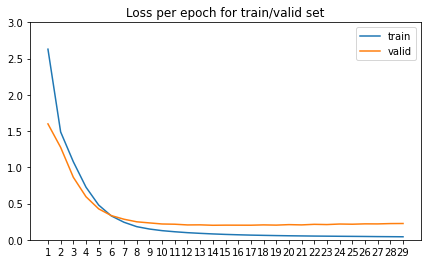

In [327]:
plot_learning_curve(train_losses, valid_losses)

## Evaluation

### Validating and Testing

In [421]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

In [425]:
# get top-1 accuracy for validation set

correct_valid, total_valid = inference_with_metrics(model, valid_dl, classes=list(value2pos.keys()))

In [426]:
# get top-1 accuracy for test set

correct_test, total_test = inference_with_metrics(model, test_dl, classes=list(value2pos.keys()))

In [427]:
print(
    f"Valid Top-1 Accuracy: {correct_valid['all'] / total_valid['all']:.4f}\n"
    f"Test Top-1 Accuracy: {correct_test['all'] / total_test['all']:.4f}"
)

Valid Top-1 Accuracy: 0.8793
Test Top-1 Accuracy: 0.8740


### Analysis

In [412]:
metrics_df = get_analysis_dataframe(value2pos, correct_valid, correct_test, total_valid, total_test)

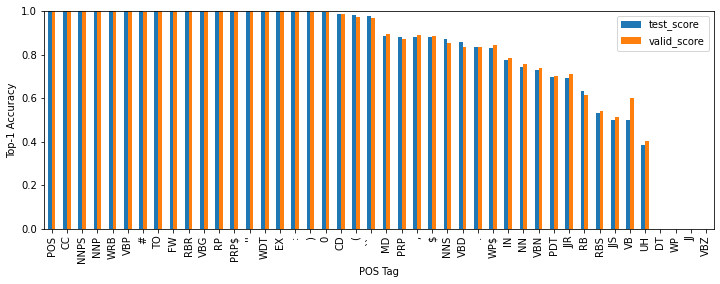

In [413]:
metrics_df.plot(
    x="tag", 
    y=["test_score", "valid_score"], 
    kind="bar", 
    ylim=(0,1), 
    figsize=(12, 4), 
    xlabel="POS Tag", 
    ylabel="Top-1 Accuracy"
);

In [456]:
metrics_df["test_samples_perc"] = metrics_df["test_samples"].div(metrics_df["test_samples"].sum(),axis=0)
metrics_df["valid_samples_perc"] = metrics_df["valid_samples"].div(metrics_df["valid_samples"].sum(),axis=0)

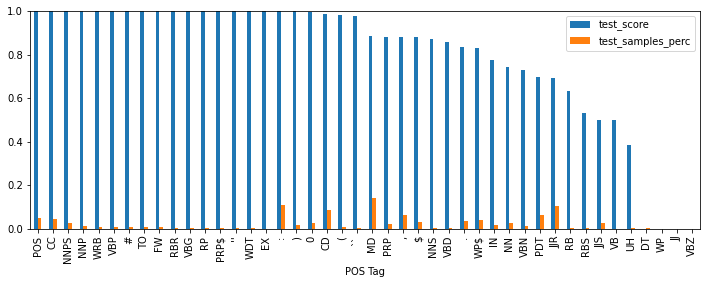

In [458]:
metrics_df.plot(
    x="tag", 
    y=["test_score", "test_samples_perc"], 
    kind="bar", 
    ylim=(0,1), 
    figsize=(12, 4), 
    xlabel="POS Tag"
);

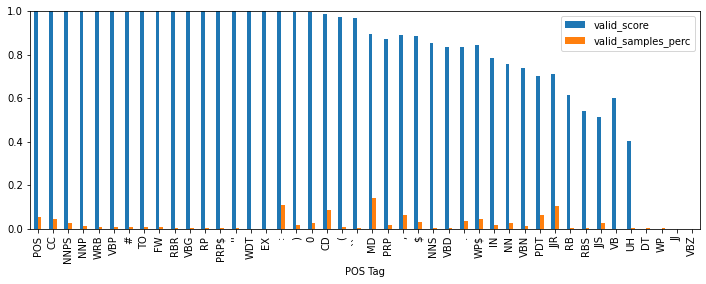

In [459]:
metrics_df.plot(
    x="tag", 
    y=["valid_score", "valid_samples_perc"], 
    kind="bar", 
    ylim=(0,1), 
    figsize=(12, 4), 
    xlabel="POS Tag"
);

In [415]:
metrics_df.sort_values(["test_samples"], ascending=False)

,tag,test_score,valid_score,test_samples,valid_samples
22,MD,0.886631,0.896405,6642,9624
16,:,0.999211,0.999179,5071,7308
34,JJR,0.690595,0.711821,4806,7013
19,CD,0.986318,0.986007,4020,5717
24,",",0.879697,0.889274,3034,4326
33,PDT,0.697031,0.702921,2964,4211
0,POS,1.000000,1.000000,2390,3474
1,CC,1.000000,1.000000,1975,2859
29,WP$,0.829510,0.843830,1918,3112
28,.,0.834425,0.833133,1679,2499


- 

## Further Ideas

#### Data Preprocessing

In terms of preprocessing, I noticed that around 5000 words are not in the Word2Vec vocabulary. These include a lot of numbers (most of them having the POS tag "CD") and hyphenated words.

My idea for handling numbers would be to replace them with a unique token such as "num" – however, the current models already learns the the class "CD" almost perfectly, so there probably is no need to deal with them. 

Regarding hyphenated words, I am still unsure how to handle them well. The biggest problem here is, that each word in the sentence corresponds to a POS tag. Splitting the hyphenated word into two words would result in a sentence that has one token more than its target, thus messing up how tags are assigned to tokens in the particular sample. One idea would be to still split hyphenated words and duplicate its POS tag. This way `("friendly-looking", "JJ")` would become `("friendly", "JJ"), ("looking", "JJ")`. 

As noted in the written-up analysis, some of the punctuation (such as `.` and `'`) is not learned perfectly. What could allow the model to better learn them is to simply drop them for tokens that also include letters or digits. That way a token only consising of punctuation would be retained (i.e., `.` would still be `.`) but tokens such as `1.45` or `'s` would be converted to `145` or `s`, thus not confusing the model.

#### Model
The model I used is quite simple – one embedding, one RNN layer and one Conv layer – so there is a lot of room to experiment around with the architecture:
- the RNN layer could be replaced with a GRU or LSTM layer
- the number of RNN/GRU/LSTM layers could be increased
- the number of hidden dimensions could be increased

However, making the model more complex also holds the danger of overfitting (especially given the not-so-large dataset at hand), against which some measures could be taken:
- apply Dropout
- experiment with different values for weight decay

Of course, RNNs (as well as GRUs and LSTMs) come with their disadvantages. In general, they have problems with long-range dependencies and are slow to train. These problems are better handled by more recent NLP transformer models. One idea, thus, would be to finetune a pretrained BERT model. However, given the limited data we have, it might be a bit overkill to use BERT, but it may still be worth a try.

#### Analysis

There's also lots of room for further analsis of results. I had a look at the global and per-class top-1 accuracy, which gave me a general feeling of how well the model performs. Calculating and plotting a confusion matrix would provide an even better insight into the model's performance and would give information about which classes are frequently mixed up (although a confusion matrix with 45 classes might take a little bit of time to fully take in).

Comparing predictions and ground truth sample by sample might also provide some useful information why some of the classes were not learned that well. 